In [ ]:
!pip install -Uqq fastai
!pip install -Uqq fastbook
!pip install -Uqq matplotlib
!pip install -Uqq scipy
!pip install -Uqq numpy

## Package Imports

In [4]:
from fastbook import *
from fastai.vision.widgets  import *

import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import numpy as np

## Test audio download and Spectrogram Plot (Skip if needed)

In [4]:
files = ['https://francisco-test.s3.us-east-2.amazonaws.com/Audio/SampleAI.wav']

dest = 'audio/sample.wav'
download_url(files[0], dest)

Path('audio/sample.wav')

In [5]:
sr, samples = wavfile.read(dest)
fqs, times, spectrogram = signal.spectrogram(samples, sr)

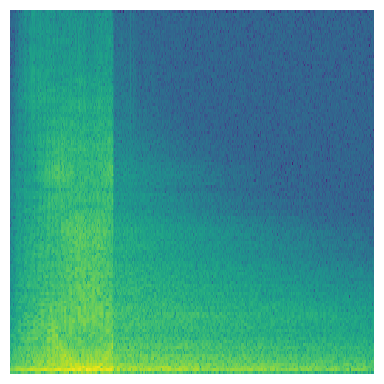

In [8]:
plt.figure(figsize=(4, 4))
plt.pcolormesh(times, fqs, 10 * np.log10(spectrogram))
# Hide axis
plt.axis('off')
# Remove whitespace
plt.margins(0)
# plt.imshow(spectrogram)
plt.tight_layout()

plt.show()

## Batch file processing

To start from somewhere, I'll make this audio classification notebook a musical instrument classifier, but you can replace this with any audio category you want to work with.

Below is the source url of the files, an S3 bucket in this case, and in the `categories_dict` dictionary there's a key that represents a directory, and a value that represents the total number of files. The file names will follow the convention, s3_url/piano/piano001

In [5]:
s3_bucket = 'https://francisco-test.s3.us-east-2.amazonaws.com/Audio/'
# dictionary with the categories and the number of wav files in each
categories_dict = {
    "drums": 40,
    "electricguitar": 16,
    "piano": 16,
    "voice": 29,
}

### Pad zeros helper
Function to pad an integer between 1-100 with zeros

In [6]:
def pad_zeros(num):
    if not isinstance(num, int) or num < 1 or num > 100:
        raise ValueError("Input must be an integer between 1 and 100")

    padded_num = f"{num:03d}"
    return padded_num

### Set up paths

In [8]:
import os.path

categories = 'drums', 'electricguitar', 'piano', 'voice'
path = Path('audio')
image_path = Path('images')

### Download audio files and process into spectrogram (Skip if files already loaded)
The files are stored in S3 in folders with the `categories_dict` keys as names, and the numeric value is the nu,ber of files on each category.

In [ ]:
plt.figure(figsize=(4,4))

if not path.exists():
    path.mkdir()

if not image_path.exists():
    image_path.mkdir()

for category, num_files in categories_dict.items():
    dest = (path/category)
    image_dest = (image_path/category)
    print(dest, image_dest)
    
    dest.mkdir(exist_ok=True)
    image_dest.mkdir(exist_ok=True)
    
    # (audio url, audio file download destination, image file destination)[]
    files = [
        (
            f'{s3_bucket}{category}/{category}{pad_zeros(i)}.wav',
            f'{dest}/{pad_zeros(i)}.wav',
            f'{image_dest}/{pad_zeros(i)}.png'
        ) 
        for i in range(1,num_files+1)
    ]

    for ff in files:
        src = ff[0]
        destination = ff[1]
        image_destination = ff[2]
        
        # Download wav (Skip if already downloaded)
        check_audio_file = os.path.isfile(destination)
        if not check_audio_file:
            print(f'downloading {ff[0]} as {ff[1]}')
            download_url(src, destination)
        
        # Analyze wav file
        sr, samples = wavfile.read(destination)
        fqs, times, spectrogram = signal.spectrogram(samples, sr)
        plt.pcolormesh(times, fqs, 10 * np.log10(spectrogram))
        # Hide axis
        plt.axis('off')
        # Remove whitespace
        plt.margins(0)
        plt.savefig(image_destination)
        
print('Done')

## Images and verify

In [9]:
fns = get_image_files(image_path)
fns

(#101) [Path('images/voice/022.png'),Path('images/voice/004.png'),Path('images/voice/027.png'),Path('images/voice/024.png'),Path('images/voice/001.png'),Path('images/voice/007.png'),Path('images/voice/014.png'),Path('images/voice/012.png'),Path('images/voice/015.png'),Path('images/voice/016.png')...]

### Remove failed files

In [10]:
failed = verify_images(fns)
failed

(#0) []

## Train data

In [12]:
audios = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # Independen var ImageBlock (what we are predicting), dependent var CategoryBlock target
    get_items=get_image_files, # how to get images. get_image_files gets all the images in a fiven path (arg)
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # Split training and testing data (80-20). Seed, starting point in the list
    get_y=parent_label, # parent_label takes the name of the file's containing directory
    item_tfms=RandomResizedCrop(224, min_scale=0.5), # Make all images same size to be able to add them to tensor (array) that goes through the model.
    batch_tfms=aug_transforms(),
)

dls = audios.dataloaders(image_path)

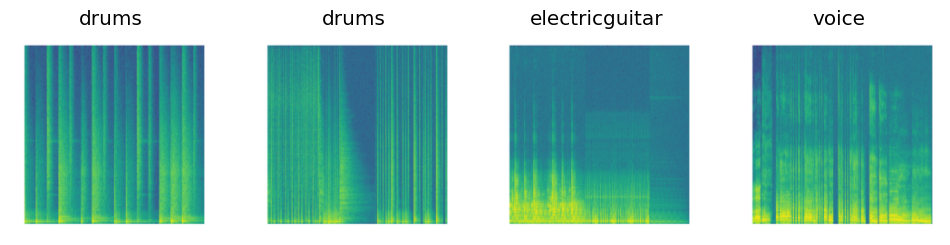

In [13]:
dls.valid.show_batch(max_n=4, nrows=1)

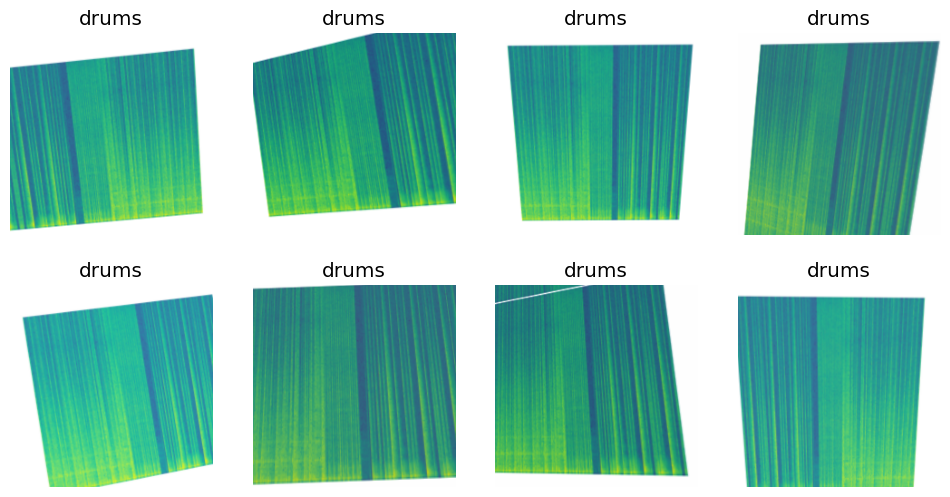

In [14]:
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [15]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 127MB/s] 


epoch,train_loss,valid_loss,error_rate,time
0,2.116673,1.215765,0.450000,00:03


epoch,train_loss,valid_loss,error_rate,time
0,2.147604,1.128516,0.400000,00:02
1,2.154161,1.040037,0.200000,00:02
2,1.801715,0.962993,0.200000,00:02
3,1.618661,0.824405,0.200000,00:02


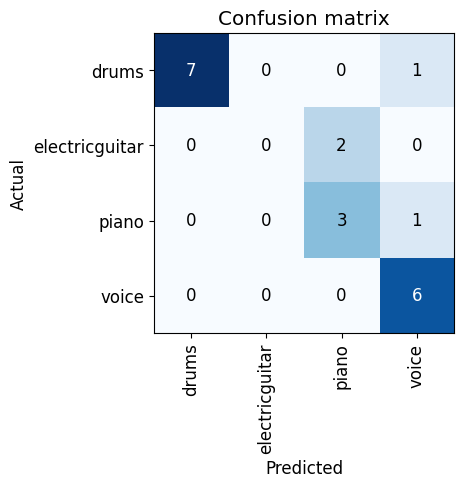

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

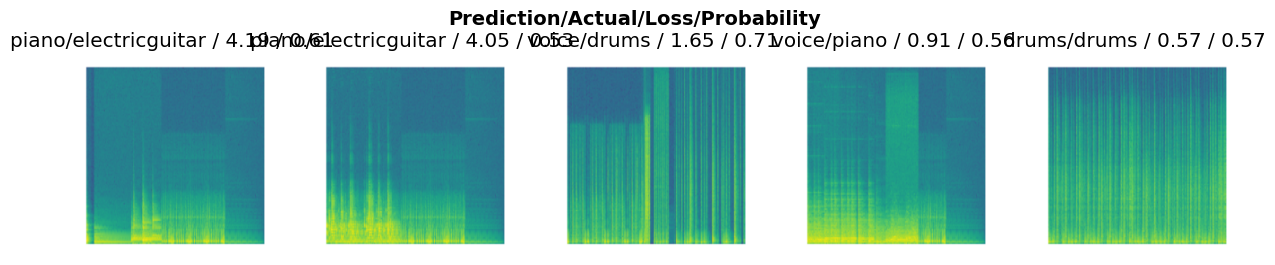

In [17]:
# Plot top losses
interp.plot_top_losses(5, nrows=1)

In [18]:
# Data cleaning GUI - Image classifier cleaner
cleaner = ImageClassifierCleaner(learn)
cleaner

Code to clean elemets deleted or swapped in the UI

In [ ]:
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

# Export model

In [19]:
learn.export()
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

### Delete png file helper
In case you need to delete files to reprocess them

In [ ]:
def delete_png_files(directory):
    """
    Delete all files with a .png extension in the specified directory.

    Args:
        directory (str): Path to the directory where files will be deleted.
    """
    # Iterate over all files in the directory
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        
        # Check if the file is a regular file and ends with .png extension
        if os.path.isfile(file_path) and filename.lower().endswith('.png'):
            try:
                # Attempt to remove the file
                os.remove(file_path)
                print(f"Deleted: {file_path}")
            except OSError as e:
                # Handle error (e.g., permission denied, file not found)
                print(f"Error deleting {file_path}: {e}")

# delete_png_files('images')

In [ ]:
delete_png_files('images')